In [ ]:
!pip install contractions emoji transformers pandas scipy torchvision torch tqdm datasets

In [2]:
import ast
import pandas as pd
import contractions
import emoji
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import numpy as np
import os
import glob
import datetime
from tqdm import tqdm
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt


# Preprocess

In [3]:
dir = './drive/MyDrive/Colab Notebooks/'
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


def twitter_roberta_tokenize(text, tokenizer):
    return tokenizer(
        text,
        padding="max_length",     # ensures all sequences are the same length
        truncation=True,
        max_length=128,
        return_tensors=None       # keep outputs as lists
    )

def preprocess_internal(df,
               tokenize,  # tokenize here is a function. Example shown below
               tokenizer,
               to_lower=True,
               remove_urls=True,
               remove_emojis=True,
               remove_contractions=True,
               remove_punctuation=True):
    print("Preprocessing started")
    if df is None or df.empty:
        return None

    df['text_cleaned'] = df['text'].copy()
    if (to_lower):
        df['text_cleaned'] = df['text'].str.lower()
    if (remove_urls):
        df['text_cleaned'] = df['text_cleaned'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    if (remove_emojis):
        df['text_cleaned'] = df['text_cleaned'].apply(lambda x: emoji.demojize(x))
    if (remove_contractions):
        df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x))
    if (remove_punctuation):
        df['text_cleaned'] = df['text_cleaned'].str.replace(r'[^\w\s\']', '', regex=True)

    encoded_outputs = tokenize(df['text_cleaned'].tolist(), tokenizer)
    df["input_ids"] = encoded_outputs["input_ids"]
    df["attention_mask"] = encoded_outputs["attention_mask"]

    result_df = df[["id", "user", "date", "text", "text_cleaned", "input_ids", "attention_mask", "target"]]
    return result_df

def load_and_preprocess_sentiment140(csv_path, sample_per_class=100_000):
    print("Loading dataset...")
    columns = ['target', 'id', 'date', 'query', 'user', 'text']
    df = pd.read_csv(csv_path, encoding='latin-1', names=columns)

    # Convert sentiment labels: 0=neg, 2=neutral, 4=pos → 0,1,2
    df['target'] = df['target'].replace({0: 0, 2: 1, 4: 2})

    # Drop unnecessary columns early
    df = df[['target', 'id', 'date', 'user', 'text']]

    # Balance dataset
    df_balanced = df.groupby('target').apply(lambda x: x.sample(sample_per_class, random_state=42)).reset_index(drop=True)
    print(f"Sampled {sample_per_class} tweets per class.")

    # Preprocess and tokenize
    processed_df = preprocess_internal(df_balanced, twitter_roberta_tokenize, tokenizer)
    print("Preprocessing complete.")

    return processed_df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Load and preprocess training data

In [4]:
# Inspect data
csv_path = "./drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv"
columns = ['target', 'id', 'date', 'query', 'user', 'text']
#df = pd.read_csv(csv_path, encoding='latin-1', names=columns)
#df["target"].value_counts()

In [ ]:
processed_df = load_and_preprocess_sentiment140(csv_path, 30000)

In [ ]:
tokenizer.save_pretrained(dir+'tokenizer')

In [ ]:
# Save preprocessed dataframes to avoid repeating work
processed_df.to_csv("./drive/MyDrive/Colab Notebooks/processed.60000.csv")

In [5]:
class Sentiment140Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        # Convert columns to tensors and store as lists
        self.input_ids = df["input_ids"].apply(torch.tensor).tolist()
        self.attention_mask = df["attention_mask"].apply(torch.tensor).tolist()
        self.labels = df["target"].apply(torch.tensor).tolist() # Changed from "target" to "labels"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

In [6]:
processed_df = pd.read_csv("./drive/MyDrive/Colab Notebooks/processed.60000.csv")
processed_df['input_ids'] = processed_df['input_ids'].apply(ast.literal_eval)
processed_df['attention_mask'] = processed_df['attention_mask'].apply(ast.literal_eval)

In [7]:
train_df, val_df = train_test_split(processed_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [8]:
train_dataset = Sentiment140Dataset(train_df)
val_dataset = Sentiment140Dataset(val_df)

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Specify training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Output directory for saved models
    evaluation_strategy="epoch",         # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    num_train_epochs=3,                  # Number of epochs
    weight_decay=0.01,                   # Weight decay for regularization
    logging_dir='./logs',                # Directory for logs
)

# Initialize the Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

#Train the Model

In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

print("Evaluation Results:")
print(eval_results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.331800,0.316014,0.871583,0.871655,0.871583,0.871590
2,0.252500,0.370119,0.871750,0.871769,0.871750,0.871737
3,0.184300,0.510409,0.869250,0.869488,0.869250,0.869256


Evaluation Results:
{'eval_loss': 0.5104085803031921, 'eval_accuracy': 0.86925, 'eval_precision': 0.8694878060193759, 'eval_recall': 0.86925, 'eval_f1': 0.8692555978130944, 'eval_runtime': 76.5132, 'eval_samples_per_second': 156.836, 'eval_steps_per_second': 9.802, 'epoch': 3.0}


In [ ]:
model.save_pretrained('./drive/MyDrive/Colab Notebooks/sentiment140_twitter_roberta_model')

# Get all Elections Data

In [ ]:
start_date = datetime.date(2024, 5, 1)
end_date = datetime.date(2024, 11, 30)
delta = datetime.timedelta(days=1)

In [ ]:
files_to_download = []
current = start_date
while current <= end_date:
    files_to_download.append(current.strftime("%Y-%m-%d"))
    current += delta

print(files_to_download)

dir = './drive/MyDrive/Colab Notebooks/'
path_to_download = dir + 'election_data'

!mkdir -p '{path_to_download}'

final_csv_filename = 'combined_daily_dataset_8000.csv'
if not os.path.exists(os.path.join(path_to_download, final_csv_filename)):
  dfs = []
  for file in files_to_download:
    url = f"https://github.com/YupengHuangFrank/ECE1513/raw/refs/heads/main/Date-Ordered-Data/{file}.csv.gz"
    filename = file + '.csv.gz'
    try:
      single_df = pd.read_csv(url, compression='gzip', usecols=['text', 'date'])
      # n_samples = min(2000, len(single_df))
      n_samples = min(8000, len(single_df))
      sample_df = single_df.sample(n=n_samples, random_state=39)
      dfs.append(sample_df)
      print(f"Processed {filename}: sampled {n_samples} rows.")
    except Exception as e:
      print(f"Error processing csv {filename}: {e}")

  combined_df = pd.concat(dfs, ignore_index=True)
  # Save the combined DataFrame to csv for future load
  combined_file = os.path.join(path_to_download, final_csv_filename)
  combined_df.to_csv(combined_file, index=False)
  print(f"Combined csv saved at: {combined_file}")
else:
  combined_df = pd.read_csv(dir + 'election_data/' + final_csv_filename)
  print('Already combined, read from existing csv!')

print(combined_df)

In [ ]:
def preprocess_data_cleaning(df):
  # First we lower case the data
  df['text_cleaned'] = df['text'].apply(lambda x: x.lower())
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'(http\S+|www\.\S+)', '', regex=True) # Remove url
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'<.*?>', '', regex=True) # remove html tags
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: emoji.demojize(x)) # remove emojis
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True) # remove special characters
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x)) # Fix contractions
  return df

In [ ]:
# Load the election df into dataset to allow for batch processing
combined_df = pd.read_csv(dir + 'election_data/' + final_csv_filename)
combined_df = preprocess_data_cleaning(combined_df)
combined_df.to_csv(dir + 'election_data/cleaned_combined_daily_dataset_8000.csv')

In [ ]:
combined_df = pd.read_csv(dir + 'election_data/cleaned_combined_daily_dataset_8000.csv')

In [ ]:
from datasets import Dataset

combined_election_dataset = Dataset.from_pandas(combined_df)

In [ ]:
combined_election_dataset = combined_election_dataset.remove_columns(['text'])

In [ ]:
# Now we tokenize the combined election dataset
# Load the twitter roberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(dir + 'tokenizer', use_fast=False)

# Function to tokenize the text in batches
def tokenize(text_batch, tokenizer):
  try:
    return tokenizer(
      text_batch['text_cleaned'],
      truncation=True,
      padding='max_length',
      max_length=128,
      return_tensors="pt"
    )
  except Exception as e:
    print(f"Error tokenizing batch: {e}")
    print(text_batch)
    return None

In [ ]:
tokenized_election_dataset = combined_election_dataset.map(lambda x: tokenize(x, tokenizer), batched=True)

Map:   0%|          | 0/1438001 [00:00<?, ? examples/s]

Error tokenizing batch: Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.
{'Unnamed: 0': [156000, 156001, 156002, 156003, 156004, 156005, 156006, 156007, 156008, 156009, 156010, 156011, 156012, 156013, 156014, 156015, 156016, 156017, 156018, 156019, 156020, 156021, 156022, 156023, 156024, 156025, 156026, 156027, 156028, 156029, 156030, 156031, 156032, 156033, 156034, 156035, 156036, 156037, 156038, 156039, 156040, 156041, 156042, 156043, 156044, 156045, 156046, 156047, 156048, 156049, 156050, 156051, 156052, 156053, 156054, 156055, 156056, 156057, 156058, 156059, 156060, 156061, 156062, 156063, 156064, 156065, 156066, 156067, 156068, 156069, 156070, 156071, 156072, 156073, 156074, 156075, 156076, 156077, 156078, 156079, 156080, 156081, 156082, 156083, 156084, 156085, 156086, 156087, 156088, 156089, 156090, 156091, 156092, 156093, 156094, 156095, 156096, 156097, 156098, 156099, 156100, 156101, 156102, 156103, 156104, 156105, 156106, 156107, 156

In [ ]:
tokenized_election_dataset.save_to_disk(dir + 'election_data/tokenized_election_dataset')

Saving the dataset (0/3 shards):   0%|          | 0/1436001 [00:00<?, ? examples/s]

In [ ]:
tokenized_election_dataset = Dataset.load_from_disk(dir + 'election_data/tokenized_election_dataset')

In [ ]:
tokenized_election_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

# Get prediction

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(dir + 'sentiment140_twitter_roberta_model')

In [ ]:
election_dataloader = DataLoader(tokenized_election_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

with torch.no_grad():
    for batch in tqdm(election_dataloader, desc="Predicting"):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)
        predictions.extend(batch_predictions.tolist())

Predicting: 100%|██████████| 22438/22438 [2:29:06<00:00,  2.51it/s]


In [ ]:
tokenized_election_dataset.reset_format()
tokenized_election_dataset = tokenized_election_dataset.add_column("prediction", predictions)
print(tokenized_election_dataset[3])
unique_values = tokenized_election_dataset.unique('prediction')
print(unique_values)

{'Unnamed: 0': 3, 'date': '2024-05-01', 'text_cleaned': 'democrats bags  biden and gullible supporters ', 'input_ids': [0, 12789, 33335, 5565, 1437, 2311, 225, 8, 37957, 4748, 2732, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'prediction': 0}
[2, 0]


In [ ]:
prediction_df = tokenized_election_dataset.to_pandas()
prediction_df.to_csv(dir + 'election_data/election_prediction_data.csv', columns=['date', 'text_cleaned', 'prediction'], index=False)

In [ ]:
prediction_df = pd.read_csv(dir + 'election_data/election_prediction_data.csv')

In [ ]:
prediction_df.head()

,date,text_cleaned,prediction
0,2024-05-01,trump rolls out the red carpet for foreign lea...,2
1,2024-05-01,donald trump takes biggest lead ever over joe ...,2
2,2024-05-01,phonylyinglibs obriedave1 debrasc69769469 retu...,0
3,2024-05-01,democrats bags biden and gullible supporters,0
4,2024-05-01,whitneychanell almasuono not sure what there i...,0


In [ ]:
prediction_df['prediction'].value_counts()
sentiment_to_popularity = {0: -1, 1: 0, 2: 1}
prediction_df['prediction'] = prediction_df['prediction'].map(sentiment_to_popularity)


In [ ]:
prediction_df['prediction'].value_counts()


,count
prediction,
-1,735376
1,700625


# Detect candidate 1

In [25]:
def detect_candidate_1(text):
    text = text.lower()
    group1 = ['joe', 'biden', 'kamala', 'harris', 'democrat', ]
    group2 = ['donald', 'trump', 'gop', 'maga', 'republican']
    if any(name in text for name in group1) and any(name in text for name in group2):
      group1_indices = [text.find(name) for name in group1 if text.find(name) != -1]
      group2_indices = [text.find(name) for name in group2 if text.find(name) != -1]
      if min(group1_indices) < min(group2_indices):
        return 'biden-kamala'
      else:
        return 'trump'
    elif any(name in text for name in group1):
      return 'biden-kamala'
    elif any(name in text for name in group2):
      return 'trump'
    else:
      return 'other'

In [ ]:
daily_counts = prediction_df.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

In [ ]:
prediction_df['candidate'] = prediction_df['text_cleaned'].apply(detect_candidate_1)
prediction_df = prediction_df[prediction_df['candidate'] != 'other'] # Should i filter this out?
prediction_df.sort_values('date', inplace=True)
prediction_df["prediction"] = pd.to_numeric(prediction_df["prediction"], errors="coerce")
prediction_df.dropna(subset=["prediction"], inplace=True)
avg_sentiment = prediction_df.groupby(['candidate', 'date'])['prediction'].mean()
norm_sentiment = (avg_sentiment + 1) / 2
daily_norm_sum = norm_sentiment.groupby(level='date').sum()
support_percentage = norm_sentiment / norm_sentiment.index.get_level_values('date').map(daily_norm_sum) * 100
print(support_percentage)

support_percentage_df = support_percentage.unstack(level='candidate')
print(support_percentage_df)
support_percentage_df = support_percentage_df.loc[valid_dates]
support_percentage_df.index = pd.to_datetime(support_percentage_df.index)

         date                                       text_cleaned  prediction  \
0  2024-05-01  trump rolls out the red carpet for foreign lea...           1   
1  2024-05-01  donald trump takes biggest lead ever over joe ...           1   
2  2024-05-01  phonylyinglibs obriedave1 debrasc69769469 retu...          -1   
3  2024-05-01     democrats bags  biden and gullible supporters           -1   
5  2024-05-01  president bidens nightmare scenario just happe...          -1   

      candidate  
0         trump  
1         trump  
2  biden-kamala  
3  biden-kamala  
5  biden-kamala  


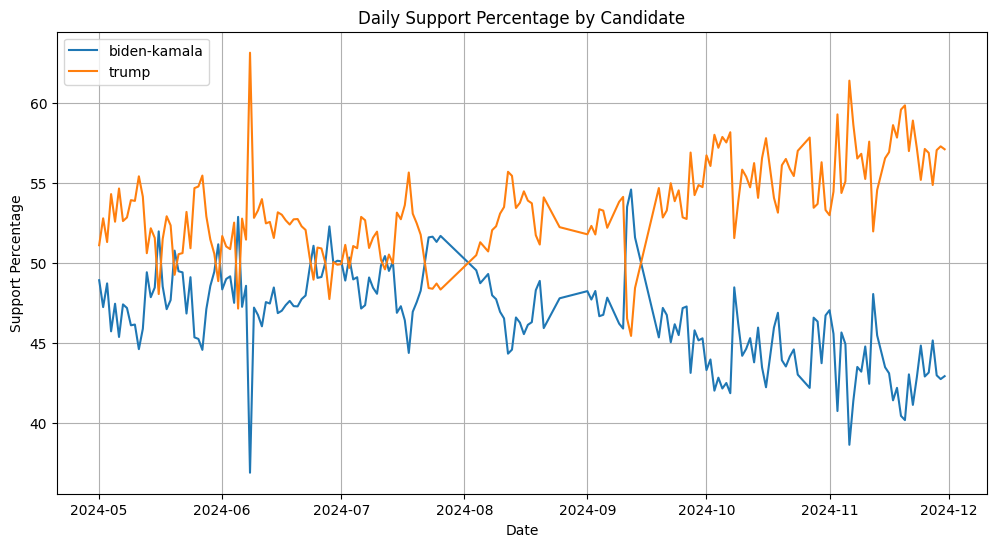

In [ ]:
plt.figure(figsize=(12, 6))
for candidate in support_percentage_df.columns:
    plt.plot(support_percentage_df.index, support_percentage_df[candidate], label=candidate)

plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Support Percentage by Candidate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df1 = pd.read_csv(dir + 'election_data/election_prediction_data.csv')
prediction_df1.dropna(inplace=True)
prediction_df1['candidate'] = prediction_df1['text_cleaned'].apply(detect_candidate_1)
prediction_df1 = prediction_df1[prediction_df1['candidate'] != 'other'] # Should i filter this out?
prediction_df1['date'] = pd.to_datetime(prediction_df1['date'])
prediction_df1.sort_values('date', inplace=True)

daily_counts = prediction_df1.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

prediction_counts_df = prediction_df1.groupby(['candidate', 'date'])['prediction'].value_counts().unstack(fill_value=0)
prediction_counts_df['total'] = prediction_counts_df[[0, 2]].sum(axis=1)
prediction_counts_df['support'] = prediction_counts_df[2] * 1 + prediction_counts_df[0] * -1
prediction_counts_df['support_percentage'] = (prediction_counts_df['support'] / prediction_counts_df['total']) * 100
prediction_counts_df = prediction_counts_df['support_percentage'].unstack(level='candidate')
prediction_counts_df = prediction_counts_df.loc[valid_dates]

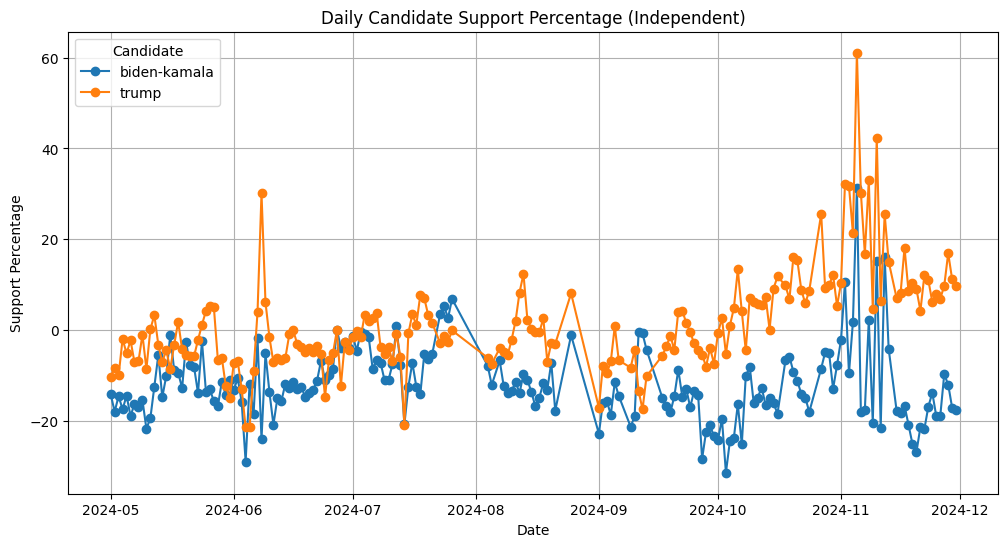

In [ ]:
plt.figure(figsize=(12,6))
for candidate in prediction_counts_df.columns:
    plt.plot(prediction_counts_df.index, prediction_counts_df[candidate], marker='o', label=candidate)
plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Candidate Support Percentage (Independent)")
plt.legend(title="Candidate")
plt.grid(True)
plt.show()

# Detecting candidates 2

In [30]:
def detect_candidate_2(text):
    text = text.lower()
    group1 = ['joe', 'biden', 'kamala', 'harris', 'democrat', ]
    group2 = ['donald', 'trump', 'gop', 'maga', 'republican']
    if any(name in text for name in group1) and any(name in text for name in group2):
      group1_indices = [text.find(name) for name in group1 if text.find(name) != -1]
      group2_indices = [text.find(name) for name in group2 if text.find(name) != -1]
      if len(group1_indices) > len(group2_indices):
        return 'biden-kamala'
      else:
        return 'trump'
    elif any(name in text for name in group1):
      return 'biden-kamala'
    elif any(name in text for name in group2):
      return 'trump'
    else:
      return 'other'

In [ ]:
prediction_df2 = pd.read_csv(dir + 'election_data/election_prediction_data.csv')
prediction_df2.dropna(inplace=True)
prediction_df2['candidate'] = prediction_df1['text_cleaned'].apply(detect_candidate_2)
prediction_df2 = prediction_df2[prediction_df2['candidate'] != 'other'] # Should i filter this out?
prediction_df2.sort_values('date', inplace=True)
prediction_df2["prediction"] = pd.to_numeric(prediction_df["prediction"], errors="coerce")
prediction_df2.dropna(subset=["prediction"], inplace=True)
avg_sentiment = prediction_df2.groupby(['candidate', 'date'])['prediction'].mean()
norm_sentiment = (avg_sentiment + 1) / 2
daily_norm_sum = norm_sentiment.groupby(level='date').sum()
support_percentage = norm_sentiment / norm_sentiment.index.get_level_values('date').map(daily_norm_sum) * 100
print(support_percentage)

support_percentage_df = support_percentage.unstack(level='candidate')
print(support_percentage_df)
support_percentage_df = support_percentage_df.loc[valid_dates]
support_percentage_df.index = pd.to_datetime(support_percentage_df.index)

candidate     date      
biden-kamala  2024-05-01    49.585780
              2024-05-02    49.252058
              2024-05-03    49.375912
              2024-05-04    48.652426
              2024-05-05    49.166682
                              ...    
trump         2024-11-26    52.958609
              2024-11-27    52.069540
              2024-11-28    53.158791
              2024-11-29    53.731329
              2024-11-30    53.082980
Length: 389, dtype: float64
candidate   biden-kamala      trump
date                               
2024-05-01     49.585780  50.414220
2024-05-02     49.252058  50.747942
2024-05-03     49.375912  50.624088
2024-05-04     48.652426  51.347574
2024-05-05     49.166682  50.833318
...                  ...        ...
2024-11-26     47.041391  52.958609
2024-11-27     47.930460  52.069540
2024-11-28     46.841209  53.158791
2024-11-29     46.268671  53.731329
2024-11-30     46.917020  53.082980

[195 rows x 2 columns]


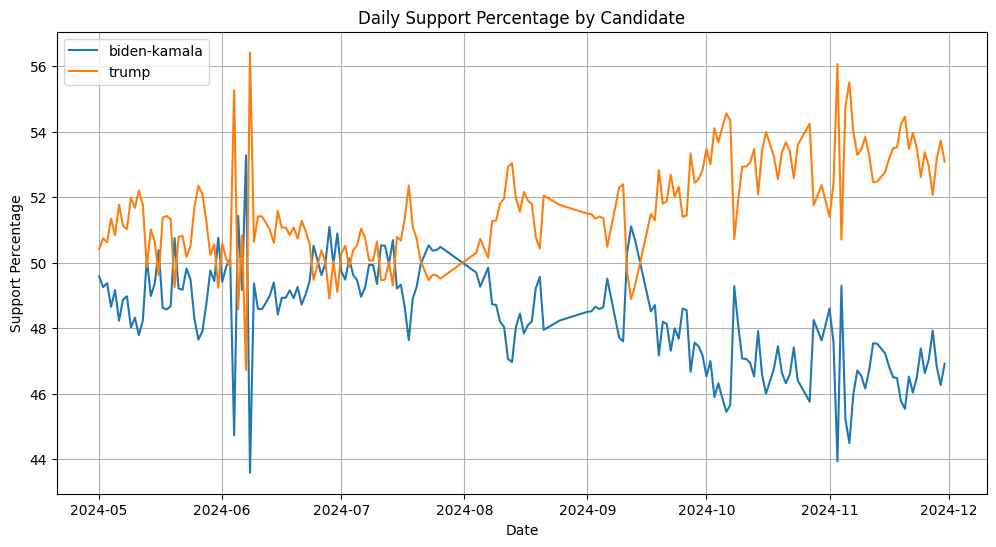

In [ ]:
plt.figure(figsize=(12, 6))
for candidate in support_percentage_df.columns:
    plt.plot(support_percentage_df.index, support_percentage_df[candidate], label=candidate)

plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Support Percentage by Candidate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df3 = pd.read_csv(dir + 'election_data/election_prediction_data.csv')
prediction_df3.dropna(inplace=True)
prediction_df3['candidate'] = prediction_df3['text_cleaned'].apply(detect_candidate_2)
prediction_df3 = prediction_df3[prediction_df3['candidate'] != 'other'] # Should i filter this out?
prediction_df3['date'] = pd.to_datetime(prediction_df3['date'])
prediction_df3.sort_values('date', inplace=True)

daily_counts = prediction_df3.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

prediction_counts_df = prediction_df3.groupby(['candidate', 'date'])['prediction'].value_counts().unstack(fill_value=0)
prediction_counts_df['total'] = prediction_counts_df[[0, 2]].sum(axis=1)
prediction_counts_df['support'] = prediction_counts_df[2] * 1 + prediction_counts_df[0] * -1
prediction_counts_df['support_percentage'] = (prediction_counts_df['support'] / prediction_counts_df['total']) * 100
prediction_counts_df = prediction_counts_df['support_percentage'].unstack(level='candidate')
prediction_counts_df = prediction_counts_df.loc[valid_dates]

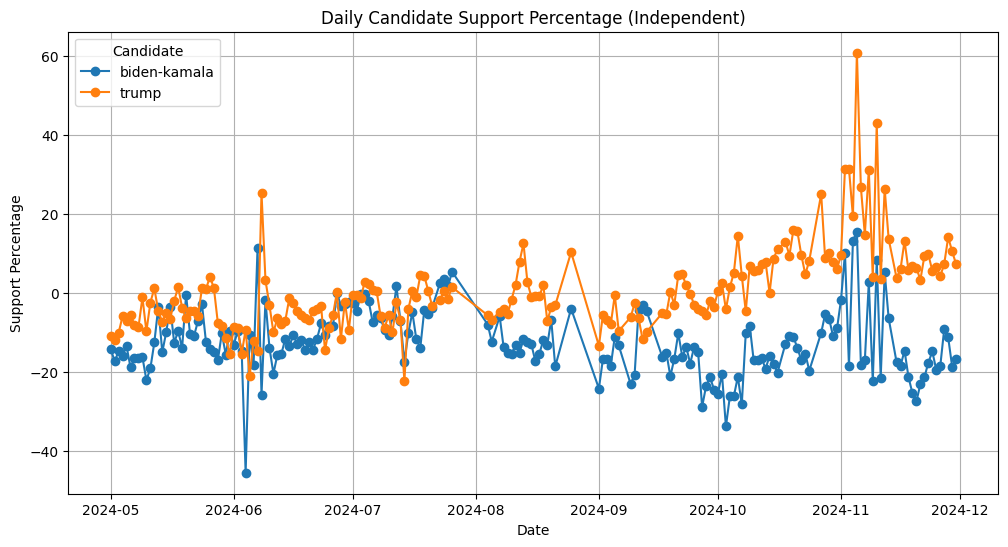

In [ ]:
plt.figure(figsize=(12,6))
for candidate in prediction_counts_df.columns:
    plt.plot(prediction_counts_df.index, prediction_counts_df[candidate], marker='o', label=candidate)
plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Candidate Support Percentage (Independent)")
plt.legend(title="Candidate")
plt.grid(True)
plt.show()

# Train the Model with less Epoch

In [15]:
model2 = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2.to(device)

# Specify training arguments
training_args2 = TrainingArguments(
    output_dir='./results',              # Output directory for saved models
    evaluation_strategy="epoch",         # Evaluate after each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,      # Batch size for training
    per_device_eval_batch_size=16,       # Batch size for evaluation
    num_train_epochs=1,                  # Number of epochs
    weight_decay=0.01,                   # Weight decay for regularization
    logging_dir='./logs',                # Directory for logs
    use_cpu=False
)

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
import torch
os.environ['WANDB_MODE'] = 'disabled'


# Train the model
trainer2.train()

# Evaluate the model
eval_results2 = trainer2.evaluate()

print("Evaluation Results for 1 epoch:")
print(eval_results2)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.318100,0.313974,0.869833,0.870015,0.869833,0.869840


Evaluation Results for 1 epoch:
{'eval_loss': 0.3139735162258148, 'eval_accuracy': 0.8698333333333333, 'eval_precision': 0.8700152061551468, 'eval_recall': 0.8698333333333333, 'eval_f1': 0.8698401600460338, 'eval_runtime': 76.8987, 'eval_samples_per_second': 156.049, 'eval_steps_per_second': 9.753, 'epoch': 1.0}


In [17]:
model2.save_pretrained('./drive/MyDrive/Colab Notebooks/sentiment140_twitter_roberta_model_2')

In [18]:
tokenized_election_dataset = Dataset.load_from_disk(dir + 'election_data/tokenized_election_dataset')

In [20]:
tokenized_election_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

In [21]:
election_dataloader = DataLoader(tokenized_election_dataset, batch_size=64)

model2.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

predictions = []

with torch.no_grad():
    for batch in tqdm(election_dataloader, desc="Predicting"):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model2(**batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)
        predictions.extend(batch_predictions.tolist())

Predicting: 100%|██████████| 22438/22438 [2:29:14<00:00,  2.51it/s]


In [22]:
tokenized_election_dataset.reset_format()
tokenized_election_dataset = tokenized_election_dataset.add_column("prediction", predictions)
print(tokenized_election_dataset[3])
unique_values = tokenized_election_dataset.unique('prediction')
print(unique_values)

{'Unnamed: 0': 3, 'date': '2024-05-01', 'text_cleaned': 'democrats bags  biden and gullible supporters ', 'input_ids': [0, 12789, 33335, 5565, 1437, 2311, 225, 8, 37957, 4748, 2732, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'prediction': 0}
[2, 0]


In [23]:
prediction_df = tokenized_election_dataset.to_pandas()
prediction_df.to_csv(dir + 'election_data/election_prediction_data_2.csv', columns=['date', 'text_cleaned', 'prediction'], index=False)

In [24]:
prediction_df = pd.read_csv(dir + 'election_data/election_prediction_data_2.csv')

# Model 2 Detect candidate 1

In [35]:
daily_counts = prediction_df.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

In [27]:
prediction_df['candidate'] = prediction_df['text_cleaned'].apply(detect_candidate_1)
prediction_df = prediction_df[prediction_df['candidate'] != 'other'] # Should i filter this out?
prediction_df.sort_values('date', inplace=True)
prediction_df["prediction"] = pd.to_numeric(prediction_df["prediction"], errors="coerce")
prediction_df.dropna(subset=["prediction"], inplace=True)
avg_sentiment = prediction_df.groupby(['candidate', 'date'])['prediction'].mean()
norm_sentiment = (avg_sentiment + 1) / 2
daily_norm_sum = norm_sentiment.groupby(level='date').sum()
support_percentage = norm_sentiment / norm_sentiment.index.get_level_values('date').map(daily_norm_sum) * 100
print(support_percentage)

support_percentage_df = support_percentage.unstack(level='candidate')
print(support_percentage_df)
support_percentage_df = support_percentage_df.loc[valid_dates]
support_percentage_df.index = pd.to_datetime(support_percentage_df.index)

candidate     date      
biden-kamala  2024-05-01    48.645123
              2024-05-02    48.281387
              2024-05-03    49.055259
              2024-05-04    47.570519
              2024-05-05    48.492580
                              ...    
trump         2024-11-26    54.060012
              2024-11-27    52.817879
              2024-11-28    54.368154
              2024-11-29    54.511765
              2024-11-30    53.956598
Length: 389, dtype: float64
candidate   biden-kamala      trump
date                               
2024-05-01     48.645123  51.354877
2024-05-02     48.281387  51.718613
2024-05-03     49.055259  50.944741
2024-05-04     47.570519  52.429481
2024-05-05     48.492580  51.507420
...                  ...        ...
2024-11-26     45.939988  54.060012
2024-11-27     47.182121  52.817879
2024-11-28     45.631846  54.368154
2024-11-29     45.488235  54.511765
2024-11-30     46.043402  53.956598

[195 rows x 2 columns]


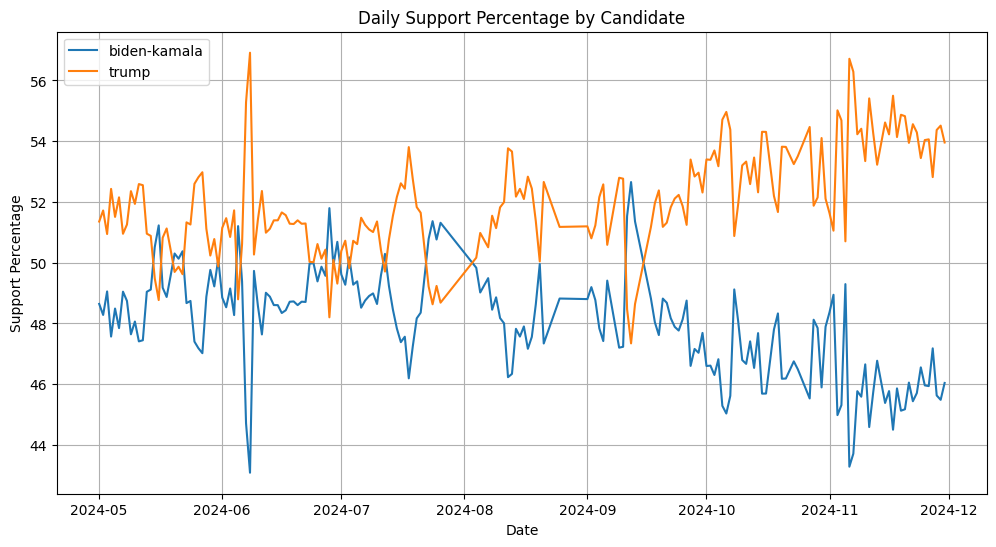

In [29]:
plt.figure(figsize=(12, 6))
for candidate in support_percentage_df.columns:
    plt.plot(support_percentage_df.index, support_percentage_df[candidate], label=candidate)

plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Support Percentage by Candidate")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
prediction_df1 = pd.read_csv(dir + 'election_data/election_prediction_data_2.csv')
prediction_df1.dropna(inplace=True)
prediction_df1['candidate'] = prediction_df1['text_cleaned'].apply(detect_candidate_1)
prediction_df1 = prediction_df1[prediction_df1['candidate'] != 'other'] # Should i filter this out?
prediction_df1['date'] = pd.to_datetime(prediction_df1['date'])
prediction_df1.sort_values('date', inplace=True)

daily_counts = prediction_df1.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

prediction_counts_df = prediction_df1.groupby(['candidate', 'date'])['prediction'].value_counts().unstack(fill_value=0)
prediction_counts_df['total'] = prediction_counts_df[[0, 2]].sum(axis=1)
prediction_counts_df['support'] = prediction_counts_df[2] * 1 + prediction_counts_df[0] * -1
prediction_counts_df['support_percentage'] = (prediction_counts_df['support'] / prediction_counts_df['total']) * 100
prediction_counts_df = prediction_counts_df['support_percentage'].unstack(level='candidate')
prediction_counts_df = prediction_counts_df.loc[valid_dates]

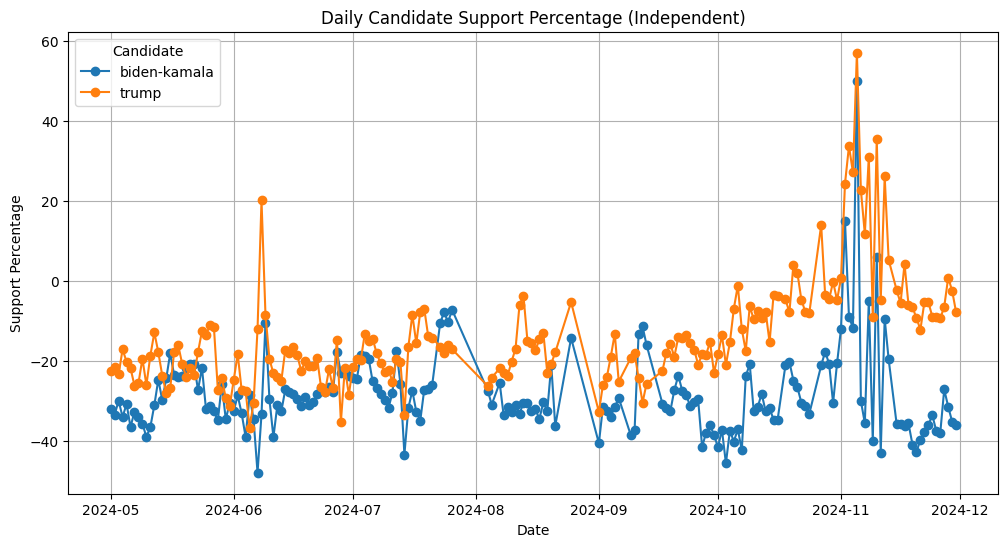

In [32]:
plt.figure(figsize=(12,6))
for candidate in prediction_counts_df.columns:
    plt.plot(prediction_counts_df.index, prediction_counts_df[candidate], marker='o', label=candidate)
plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Candidate Support Percentage (Independent)")
plt.legend(title="Candidate")
plt.grid(True)
plt.show()

# Model 2 Detect candidate 2

In [36]:
prediction_df2 = pd.read_csv(dir + 'election_data/election_prediction_data_2.csv')
prediction_df2.dropna(inplace=True)
prediction_df2['candidate'] = prediction_df2['text_cleaned'].apply(detect_candidate_2)
prediction_df2 = prediction_df2[prediction_df2['candidate'] != 'other'] # Should i filter this out?
prediction_df2.sort_values('date', inplace=True)
prediction_df2["prediction"] = pd.to_numeric(prediction_df["prediction"], errors="coerce")
prediction_df2.dropna(subset=["prediction"], inplace=True)
avg_sentiment = prediction_df2.groupby(['candidate', 'date'])['prediction'].mean()
norm_sentiment = (avg_sentiment + 1) / 2
daily_norm_sum = norm_sentiment.groupby(level='date').sum()
support_percentage = norm_sentiment / norm_sentiment.index.get_level_values('date').map(daily_norm_sum) * 100
print(support_percentage)

support_percentage_df = support_percentage.unstack(level='candidate')
print(support_percentage_df)
support_percentage_df = support_percentage_df.loc[valid_dates]
support_percentage_df.index = pd.to_datetime(support_percentage_df.index)

candidate     date      
biden-kamala  2024-05-01    49.478478
              2024-05-02    49.076001
              2024-05-03    49.601155
              2024-05-04    48.142496
              2024-05-05    48.910805
                              ...    
trump         2024-11-26    53.608869
              2024-11-27    52.584631
              2024-11-28    53.892959
              2024-11-29    54.439098
              2024-11-30    53.570501
Length: 389, dtype: float64
candidate   biden-kamala      trump
date                               
2024-05-01     49.478478  50.521522
2024-05-02     49.076001  50.923999
2024-05-03     49.601155  50.398845
2024-05-04     48.142496  51.857504
2024-05-05     48.910805  51.089195
...                  ...        ...
2024-11-26     46.391131  53.608869
2024-11-27     47.415369  52.584631
2024-11-28     46.107041  53.892959
2024-11-29     45.560902  54.439098
2024-11-30     46.429499  53.570501

[195 rows x 2 columns]


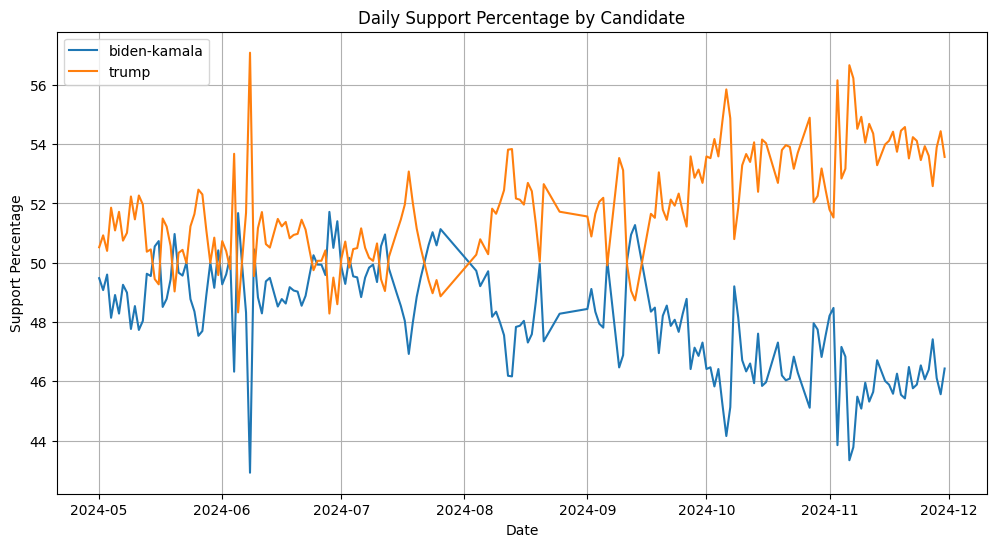

In [37]:
plt.figure(figsize=(12, 6))
for candidate in support_percentage_df.columns:
    plt.plot(support_percentage_df.index, support_percentage_df[candidate], label=candidate)

plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Support Percentage by Candidate")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
prediction_df3 = pd.read_csv(dir + 'election_data/election_prediction_data_2.csv')
prediction_df3.dropna(inplace=True)
prediction_df3['candidate'] = prediction_df3['text_cleaned'].apply(detect_candidate_1)
prediction_df3 = prediction_df3[prediction_df3['candidate'] != 'other'] # Should i filter this out?
prediction_df3['date'] = pd.to_datetime(prediction_df3['date'])
prediction_df3.sort_values('date', inplace=True)

daily_counts = prediction_df3.groupby('date').size()
threshold = 1000
valid_dates = daily_counts[daily_counts >= threshold].index

prediction_counts_df = prediction_df3.groupby(['candidate', 'date'])['prediction'].value_counts().unstack(fill_value=0)
prediction_counts_df['total'] = prediction_counts_df[[0, 2]].sum(axis=1)
prediction_counts_df['support'] = prediction_counts_df[2] * 1 + prediction_counts_df[0] * -1
prediction_counts_df['support_percentage'] = (prediction_counts_df['support'] / prediction_counts_df['total']) * 100
prediction_counts_df = prediction_counts_df['support_percentage'].unstack(level='candidate')
prediction_counts_df = prediction_counts_df.loc[valid_dates]

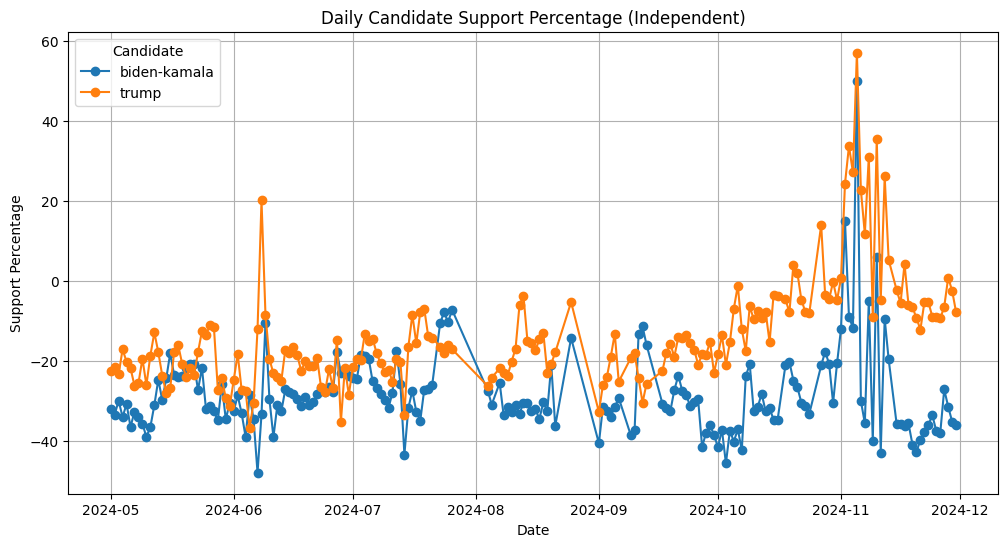

In [39]:
plt.figure(figsize=(12,6))
for candidate in prediction_counts_df.columns:
    plt.plot(prediction_counts_df.index, prediction_counts_df[candidate], marker='o', label=candidate)
plt.xlabel("Date")
plt.ylabel("Support Percentage")
plt.title("Daily Candidate Support Percentage (Independent)")
plt.legend(title="Candidate")
plt.grid(True)
plt.show()